# Assignment 3_2: Echo State Networks

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from esn import *
from learning import *

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000], y_data[:5000] # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:], y_data[5000:]

train_x, val_x = dev_x[:4000], dev_x[4000:]
train_y, val_y = dev_y[:4000], dev_y[4000:]

In [13]:
dev_x = dev_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
train_x = train_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
val_x = val_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
test_x = test_x.unsqueeze(1).unsqueeze(1)

train_x.shape, val_x.shape, dev_x.shape, test_x.shape # check shapes (L, N, D)

(torch.Size([4000, 1, 1]),
 torch.Size([1000, 1, 1]),
 torch.Size([5000, 1, 1]),
 torch.Size([5000, 1, 1]))

In [19]:
hyperparams = {
    'hidden_size': [512, 1024], 
    'ridge_regression':  [1e-6, 1e-4],
    'omhega_in': [0.2, 0.4, 0.6, 0.8],
    'omhega_b': [0.1, 0.3], 
    'rho': [0.7, 0.8, 0.9],
    'washout': [100, 1000],
}

model_selection_history = grid_search(hyperparams, train_x, train_y, val_x, val_y, n_iter=5) 

df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('esn_grid_search.csv')

In [22]:
df_results = pd.read_csv('esn_grid_search.csv', index_col=0)
df_results.sort_values(by='val_mse_mean', ascending=True).head(10)

,hidden_size,ridge_regression,omhega_in,omhega_b,rho,washout,train_mse_mean,train_mse_var,val_mse_mean,val_mse_var
config_184,1024,0.000100,0.8,0.1,0.9,100,0.000144,1.068961e-08,0.000014,1.348538e-12
config_136,1024,0.000001,0.8,0.1,0.9,100,0.000162,7.932482e-09,0.000016,7.297508e-12
config_137,1024,0.000001,0.8,0.1,0.9,1000,0.000170,3.338660e-09,0.000020,8.615807e-12
config_185,1024,0.000100,0.8,0.1,0.9,1000,0.000218,1.390231e-08,0.000018,8.827534e-12
config_41,512,0.000001,0.8,0.1,0.9,1000,0.000229,4.850298e-09,0.000044,3.799933e-11
config_40,512,0.000001,0.8,0.1,0.9,100,0.000248,1.654137e-08,0.000039,9.520515e-11
config_173,1024,0.000100,0.6,0.1,0.9,1000,0.000276,1.960416e-08,0.000012,1.588704e-12
config_29,512,0.000001,0.6,0.1,0.9,1000,0.000281,9.227745e-09,0.000030,4.600818e-12
config_124,1024,0.000001,0.6,0.1,0.9,100,0.000292,1.097834e-07,0.000009,9.578963e-13
config_28,512,0.000001,0.6,0.1,0.9,100,0.000299,8.109054e-09,0.000029,9.945574e-11


### Training MSE: 5.9e-5 - Validation MSE: 9e-6

In [8]:
esn = RegressorESN(1, 1024, 1e-6, 0.6, 0., 0.8)
h = esn.fit(dev_x, dev_y, 100)

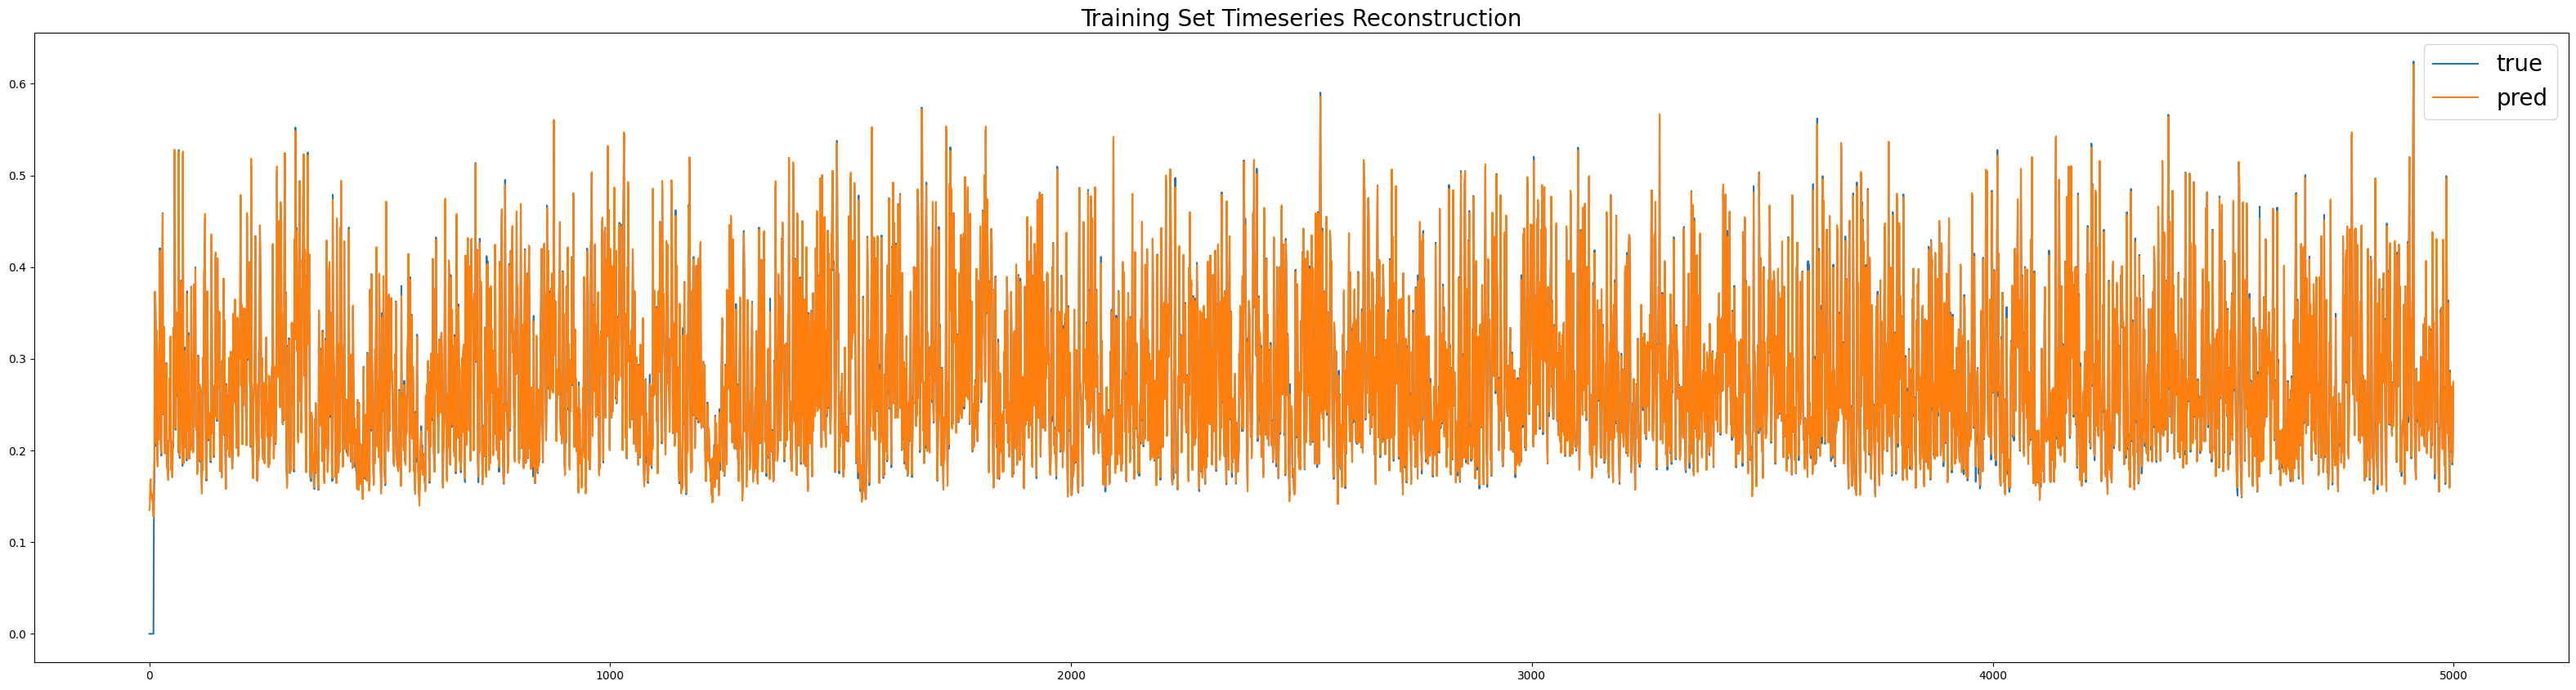

In [18]:
pred = esn(dev_x, None)

plt.figure(figsize=(40, 10))
plt.title(f'Training Set Timeseries Reconstruction', fontsize=20)
plt.plot(dev_y, label='true')
plt.plot(pred, label='pred')
plt.legend(fontsize=20)

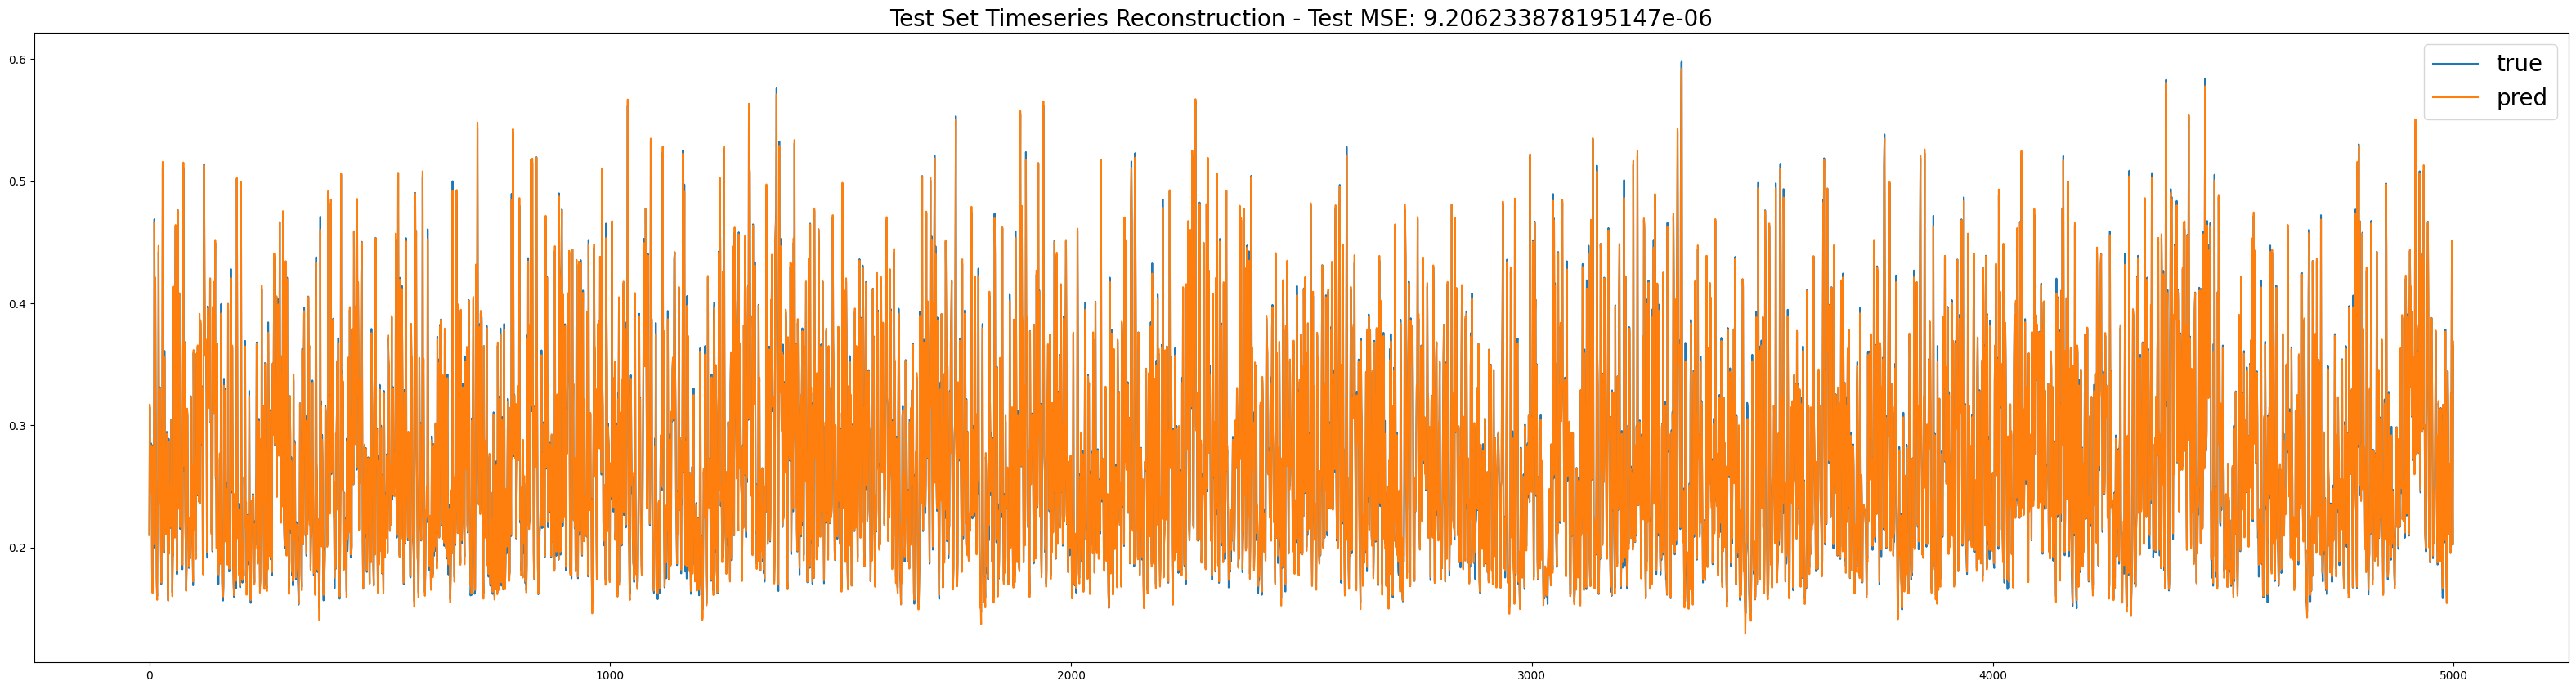

In [17]:
esn.eval()
pred = esn(test_x, h)

l = torch.nn.MSELoss()
test_loss = l(pred, test_y)

plt.figure(figsize=(40, 10))
plt.title(f'Test Set Timeseries Reconstruction - Test MSE: {test_loss.item()}', fontsize=20)
plt.plot(test_y, label='true')
plt.plot(pred, label='pred')
plt.legend(fontsize=20)